In [1]:
from sdm.utils import set_project_wd
set_project_wd()

Current Working Directory: /Users/matthewwhittle/Data Science/shefflied-bats


# Overview

This notebook uses my trained pytorch model for vegetation height prediction and runs inference on imagery stack I've prepared.

In [2]:
import torch
from sdm.models import S2DatasetInference
device = torch.device("mps")

# Load the model
model = torch.load("models/models/is-veg-cnn.pth")
model.to(device)

FileNotFoundError: [Errno 2] No such file or directory: 'models/models/is-veg-cnn.pth'

In [3]:
# Define the dataset and dataloader
from torch.utils.data import DataLoader
from sdm.config import tile_size

from torchvision.transforms.v2 import Compose, Resize

transforms = Compose([Resize(tile_size, antialias=True)])
dataset = S2DatasetInference(
    path="data/processed/s2-lidar/s2-lidar-stack.tif", image_size=tile_size, transforms=transforms
)

dataloader = DataLoader(dataset, batch_size=64, shuffle=False, pin_memory=False, num_workers=8)

In [4]:
# Run inference
from tqdm import tqdm
results = []

model.eval()
with torch.no_grad():
    for data in tqdm(dataloader):
        inputs, na_mask, spatial_info = data["inputs"], data["na_mask"], data["spatial_info"]
        
        inputs = inputs.to(device)
        output = model(inputs)
        for idx in range(output.size(0)):            
            results.append({
                "predictions": output[idx].cpu().numpy(),
                "na_mask": na_mask[idx],
                "spatial_info": spatial_info[idx]
            })
        

  0%|          | 0/22 [00:00<?, ?it/s]

100%|██████████| 22/22 [02:27<00:00,  6.72s/it]


In [8]:
import json
from sdm.models import SpatialTransformer
import numpy as np

prediction_arrays = []
for result in results:
    result["predictions"][result["na_mask"]] = np.nan
    spatial_transform = json.loads(result["spatial_info"])
    transformer = SpatialTransformer(**spatial_transform)
    array = transformer(result["predictions"])
    prediction_arrays.append(array)
    

In [10]:
paths = []
for i, tile in enumerate(prediction_arrays):
    path = f"data/processed/s2-lidar/prediction-tiles/{i}.tif"
    tile.rio.to_raster(path)
    paths.append(path)


In [11]:
import rioxarray as rxr
import xarray as xr

data = xr.open_mfdataset(paths, engine="rasterio")

In [17]:
veg_prediction_coarse = data["band_data"].coarsen(x=10, y =10, boundary="pad").mean()

veg_prediction_coarse

<xarray.DataArray 'band_data' (band: 1, y: 830, x: 1065)>
dask.array<mean_agg-aggregate, shape=(1, 830, 1065), dtype=float32, chunksize=(1, 1, 26), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 3.908e+05 3.91e+05 3.91e+05 ... 4.972e+05 4.972e+05
  * y            (y) float64 4.402e+05 4.401e+05 4.4e+05 ... 3.574e+05 3.574e+05
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area

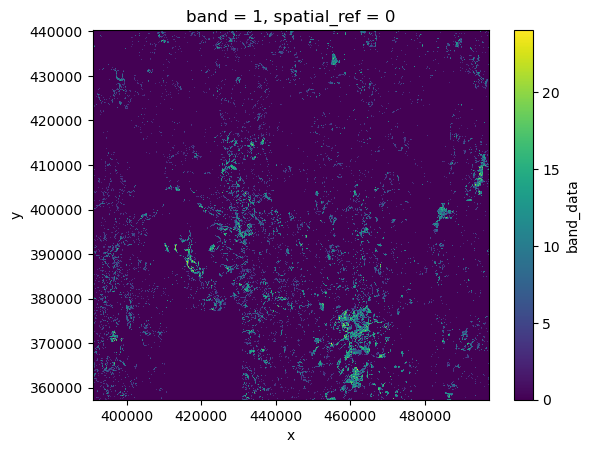

In [19]:
veg_prediction_coarse.where(veg_prediction_coarse >= 2.5, 0).plot()

In [20]:
height_range = (2.5, 25)
data = data.where(data >= height_range[0], 0)
data = data.where(data <= height_range[1], 25)


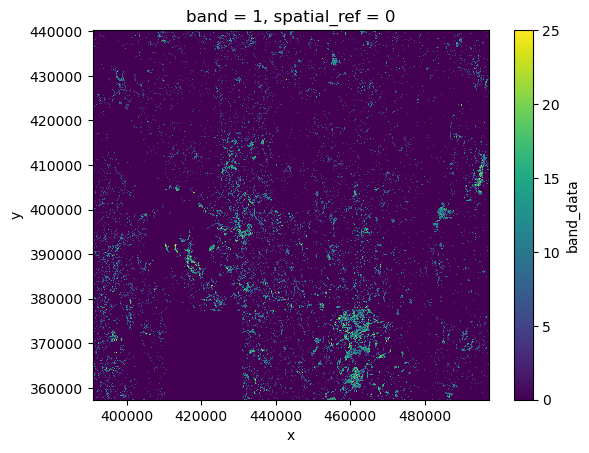

In [23]:
data["band_data"].plot()

In [25]:
data.to_array()[0].rio.to_raster("data/processed/veg-height-prediction.tif")